### ANL Sprint Week 2017
####  HSC-DR1 LSS Sprint:
Goals: https://docs.google.com/document/d/1BDW-Xvs5G2--uruhyJ-k14eoAKEipZO0Wxm_QQqH4pA/edit

--

NERSC has HSC_forced catalogs in '/project/projectdirs/lsst/LSSWG/HSC/'. Working with WIDE outputs rn.

Right now, only one file has needed columns (e.g., iclassification_extendedness): GAMA15H_PSF, downloaded with restrictions:
- detect_is_primary=True and
- icmodel_flags_badcentroid=False and
- icentroid_sdss_flags=False and
- iflags_pixel_edge=False and
- iflags_pixel_interpolated_center=False and
- iflags_pixel_saturated_center=False and
- iflags_pixel_cr_center=False and
- iflags_pixel_bad=False and
- iflags_pixel_suspect_center=False and
- iflags_pixel_clipped_any=False and
- pdr1_wide.search_gama15h(object_id)

We will need the photo-zs, randoms but the current query output doesn't have  them.

Column descriptions in: https://hsc-release.mtk.nao.ac.jp/schema/ under WIDE-pdr1_wide/catalogs/forced.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn as sns
import os
from astropy.io import fits
from astropy.table import Table
import healpy as hp
from collections import OrderedDict
from matplotlib import cm

Read in the data.

In [2]:
HSCdatapath= '/project/projectdirs/lsst/LSSWG/HSC/'
HSCFiles= os.listdir(HSCdatapath)
#HSCFiles= [f for f in HSCFiles if (f.__contains__('.fits') and f.__contains__('WIDE_WIDE'))]
HSCFiles= ['HSC_WIDE_GAMA15H_PSF_forced.fits']

In [3]:
HSCFiles= [HSCdatapath+f for f in HSCFiles]
HSCFiles

['/project/projectdirs/lsst/LSSWG/HSC/HSC_WIDE_GAMA15H_PSF_forced.fits']

In [4]:
HSCdata= {}
for filename in HSCFiles:
    key= filename.split('WIDE_')[1].split('_forced')[0]
    print key
    dat = Table.read(filename, format='fits')
    HSCdata[key] = dat.to_pandas()
    
goodKey= key

GAMA15H_PSF


Clean up

In [5]:
# drop objects with any null column entries: the sql query apparently adds a column for many columns,
# ecnoding whether the entry in the column is null or not.
isNulls= [k for k in HSCdata[goodKey].keys() if k.__contains__('isnull')] # all the columns that signify nulls

indToDrop= []
for col in isNulls:
    nullInd= np.where(HSCdata[goodKey][col]==True)[0]
    indToDrop+=nullInd
    
# find unique indexes
indToDrop= list(set(indToDrop))

if len(indToDrop)>0: # remove the objs. with any null entries
    print 'Dropped %s entries.'%len(indToDrop)
    HSCdata[goodKey]= HSCdata[goodKey].drop(indToDrop)
    
# drop the columns now. irrelevant.
HSCdata[goodKey]= HSCdata[goodKey].drop(isNulls, axis= 1)
print 'Dropped %s columns.'%len(isNulls)

Dropped 98 columns.


In [6]:
# iclassification_extendedness seems to have nans. get rid of those objects.
noClassInd= np.where(np.isnan(HSCdata[goodKey]['iclassification_extendedness']))[0]
print 'Dropped %s entries.'%len(noClassInd)
HSCdata[goodKey]= HSCdata[goodKey].drop(noClassInd, axis= 0)
print 'Final size: ', np.shape(HSCdata[goodKey])

Dropped 11670 entries.
Final size:  (7669555, 98)


In [7]:
# ok have nans in other columns too. drop row if there's a nan.
before= len(HSCdata[goodKey])
HSCdata[goodKey]= HSCdata[goodKey].dropna(axis= 0)
print 'Dropped %s rows'%(before-len(HSCdata[goodKey].keys()))
print 'Final size: ', np.shape(HSCdata[goodKey])

Dropped 7669457 rows
Final size:  (6139128, 98)


In [8]:
#HSCdata[goodKey]
list(HSCdata[goodKey].keys())

['object_id',
 'ra',
 'dec',
 'tract',
 'patch',
 'merge_peak_g',
 'merge_peak_r',
 'merge_peak_i',
 'merge_peak_z',
 'merge_peak_y',
 'gcountinputs',
 'rcountinputs',
 'icountinputs',
 'zcountinputs',
 'ycountinputs',
 'iflags_pixel_bright_object_center',
 'iflags_pixel_bright_object_any',
 'iclassification_extendedness',
 'a_g',
 'a_r',
 'a_i',
 'a_z',
 'a_y',
 'gflux_psf',
 'rflux_psf',
 'iflux_psf',
 'zflux_psf',
 'yflux_psf',
 'gflux_psf_err',
 'rflux_psf_err',
 'iflux_psf_err',
 'zflux_psf_err',
 'yflux_psf_err',
 'gflux_psf_flags',
 'rflux_psf_flags',
 'iflux_psf_flags',
 'zflux_psf_flags',
 'yflux_psf_flags',
 'gmag_psf',
 'rmag_psf',
 'imag_psf',
 'zmag_psf',
 'ymag_psf',
 'gmag_psf_err',
 'rmag_psf_err',
 'imag_psf_err',
 'zmag_psf_err',
 'ymag_psf_err',
 'gflux_aperture10',
 'rflux_aperture10',
 'iflux_aperture10',
 'zflux_aperture10',
 'yflux_aperture10',
 'gflux_aperture10_err',
 'rflux_aperture10_err',
 'iflux_aperture10_err',
 'zflux_aperture10_err',
 'yflux_aperture10_e

Plots/diagnostics

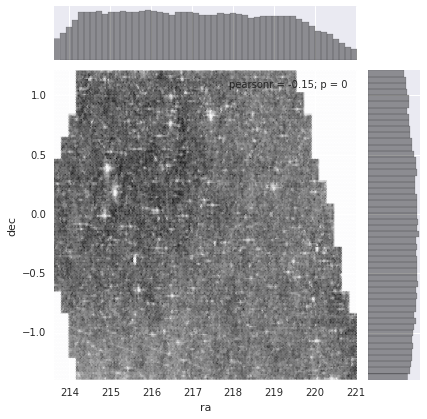

In [9]:
# plot ra, dec. in degrees.
sns.jointplot(x=HSCdata[goodKey]['ra'], y=HSCdata[goodKey]['dec'], kind="hex", color="k")

Plot the distribution of iclassification_extendedness since we'd like to consider the range of extendedness (0-1 <=> star-galaxy probability) and its impacts.

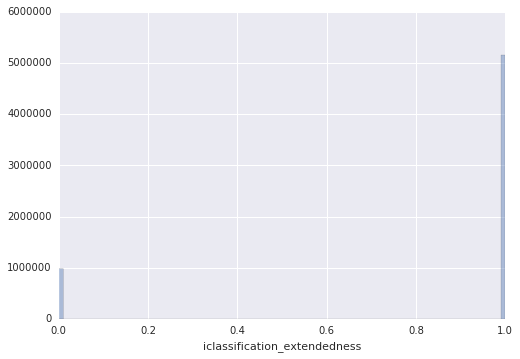

In [10]:
sns.distplot(HSCdata[goodKey]['iclassification_extendedness'], bins= 100, kde= False)

In [11]:
np.unique(HSCdata[goodKey]['iclassification_extendedness'])

array([ 0.,  1.], dtype=float32)

#### weird that iclassification_extendedness has two values only. => the classifier isn't using the better (?) classifier in DM.

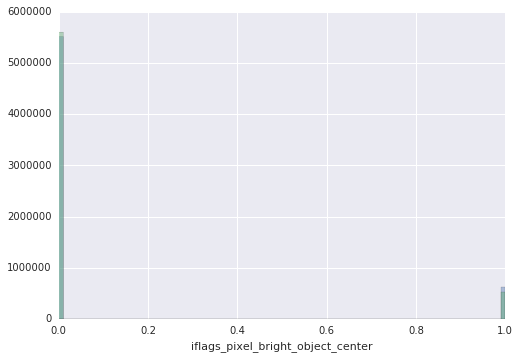

In [12]:
# check some other distributions
sns.distplot(HSCdata[goodKey]['iflags_pixel_bright_object_any'], bins= 100, kde= False)
sns.distplot(HSCdata[goodKey]['iflags_pixel_bright_object_center'], bins= 100, kde= False)

In [13]:
# bands in HSC.
bands= ['g', 'r', 'i', 'z', 'y']

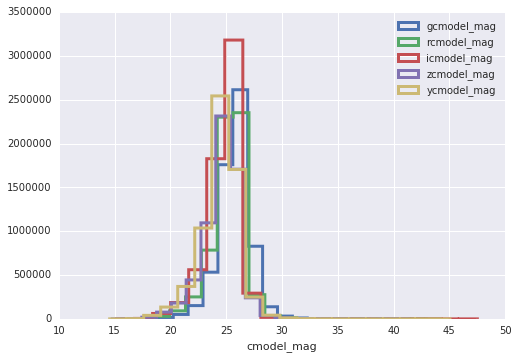

In [14]:
# plot the cmodel_mag distributions
fig, ax = plt.subplots()
for b in bands:
    key= '%scmodel_mag'%b
    plt.hist(HSCdata[goodKey][key], label= key, histtype= 'step', alpha= 1., lw= 3, bins= 20)
ax.legend()
ax.set_xlabel('cmodel_mag')

(0, 1)

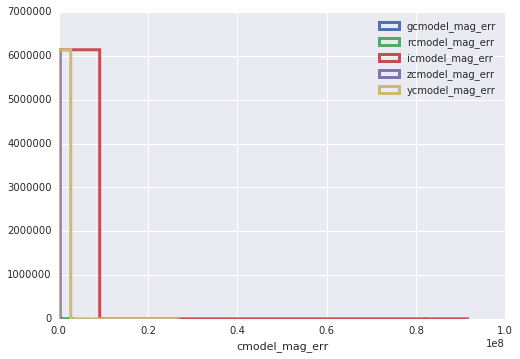

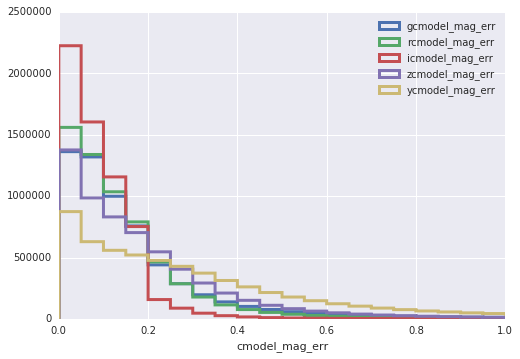

In [15]:
# plot the cmodel_mag_err distributions
fig, ax = plt.subplots()
for b in bands:
    key= '%scmodel_mag_err'%b
    plt.hist(HSCdata[goodKey][key], label= key, histtype= 'step', alpha= 1., lw= 3, bins= 10)
ax.legend()
ax.set_xlabel('cmodel_mag_err')

fig, ax = plt.subplots()
for b in bands:
    key= '%scmodel_mag_err'%b
    plt.hist(HSCdata[goodKey][key], label= key, histtype= 'step', alpha= 1., lw= 3,
             bins= list(np.arange(0, 2, 0.05))+[10])
ax.legend()
ax.set_xlabel('cmodel_mag_err')
ax.set_xlim(0,1)

Probably should look at wth is wrong with objects with O(10^8) errors on cmodel_mag.

Create the 5sigma depth maps. Need SNR to use Javier's code/

In [16]:
# calculate the SNR as flux/flux_err for each band. add as a column to the dataframe.
SNCols= []
for band in bands:
    key= '%scmodel'%band
    HSCdata[goodKey]['%s-SNR'%key]= HSCdata[goodKey]['%s_flux'%key]/HSCdata[goodKey]['%s_flux_err'%key]
    
SNCols= [k for k in HSCdata[goodKey].keys() if k.__contains__('SNR')]

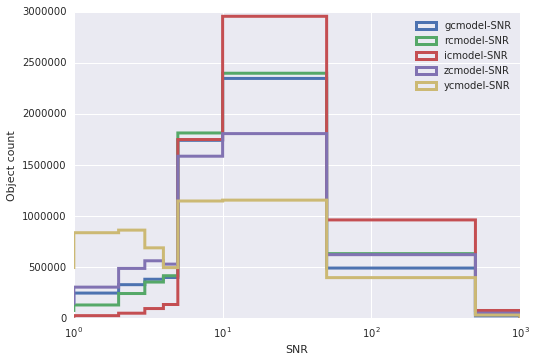

In [17]:
# plot the distbriution of the S/N
fig, ax = plt.subplots()
for key in SNCols:
    plt.hist(HSCdata[goodKey][key], label= key, histtype= 'step', alpha= 1., lw= 3,
             bins= [0., 1, 2., 3., 4., 5., 10, 50, 500, 1000])
ax.legend()
ax.set_xlabel('SNR')
ax.set_ylabel('Object count')
ax.set_xscale('log')

In [18]:
def stats(arr, returnData= False): # quick function to print/return stats on an array (min, max rn.)
    print 'Min: %s, Max: %s'%(min(arr), max(arr))
    if returnData: return min(arr), max(arr)

In [19]:
# plotting functions
cmap = cm.magma
cmap.set_under("w")
def plotSkymap(arr, title= None):
    
    nonzero= np.where(arr >0)[0]
    median= np.median(arr[nonzero])
    stddev= np.std(arr[nonzero])

    colorMin= median-1.5*stddev
    colorMax= median+1.5*stddev
                                
    if title is None: title= ''
    hp.mollview(arr, flip='astro', rot=(0,0,0), title= title, cmap=cmap, min=colorMin, max=colorMax, )
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.gcf().set_size_inches(6,6)
    plt.show()
    
def cartView(arr, raRange, decRange, title= None):
    if title is None: title= ''
    nonzero= np.where(arr >0)[0]
    median= np.median(arr[nonzero])
    stddev= np.std(arr[nonzero])

    colorMin= median-1.5*stddev
    colorMax= median+1.5*stddev
    
    hp.cartview(arr, flip='astro', rot=(0,0,0) ,
                 lonra= raRange, latra= decRange,  title= title, cmap=cmap, min=colorMin, max=colorMax, )
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.show()

In [20]:
# set up for cartview plots which needs ra, dec range.
stats(HSCdata[goodKey]['ra'])
stats(HSCdata[goodKey]['dec'])

Min: 213.613285783, Max: 221.02076895
Min: -1.39707497951, Max: 1.21047653575


In [21]:
# Must be lonra=[a,b],latra=[c,d] with a<b, c<d, a>=-180, b<=180, c>=-90, d<=+90
raRange= np.array([210, 225])-360
decRange= [-1.6, 1.5]
print raRange, decRange

[-150 -135] [-1.6, 1.5]


In [22]:
# code from Javier: /global/projecta/projectdirs/lsst/groups/LSS/DC1/scripts/map_utils.py
# creates 5sigma depth HEALPix maps
def binned_statistic(x, values, func, nbins, range):
    '''The usage is approximately the same as the scipy one
    from https://stackoverflow.com/questions/26783719/effic
    iently-get-indices-of-histogram-bins-in-python'''
    from scipy.sparse import csr_matrix
    r0, r1 = range
    mask = (x > r0) &  (x < r1)
    x = x[mask]
    values = values[mask]
    N = len(values)
    digitized = (float(nbins) / (r1-r0) * (x-r0)).astype(int)
    S = csr_matrix((values, [digitized, np.arange(N)]), shape=(nbins, N))
    return np.array([func(group) for group in np.split(S.data, S.indptr[1:-1])])

def depth_map_snr(ra,dec,mags,snr,nside=2048):
    good = np.logical_or(np.logical_not(np.isnan(ra)),np.logical_not(np.isnan(dec)))
    pix_nums = np.array(hp.ang2pix(nside,np.pi/2.-dec[good]*np.pi/180,ra[good]*np.pi/180))
    map_out = np.zeros(12*nside**2)
    #Binned statistic 2d is awfully slow (because it doesn't use the fact that all bins are equal width
    #median_snr, xed, _, _ = binned_statistic_2d(mags,pix_nums,snr,statistic='median',bins=(50,12*nside**2),range=[(20,30),(0,12*nside**2)])
    #bin_centers = 0.5*xed[1:]+0.5*xed[:-1]
    #depth = bin_centers[np.argmin(np.fabs(median_snr-5),axis=0)]
    map_out = np.zeros(12*nside**2)
    bin_centers = np.linspace(22+6/30.,28-6/30.,30.)
    for px in np.unique(pix_nums):
        mask = px==pix_nums
        if np.count_nonzero(mask)>0:
            median_snr = binned_statistic(mags[mask],snr[mask],np.nanmedian,nbins=30,range=(22,28))
            mask2 = np.isnan(median_snr)==False
            if np.count_nonzero(mask2)>0:
                depth = bin_centers[mask2][np.argmin(np.fabs(median_snr[mask2]-5.))] 
                map_out[px]=depth
            else:
                map_out[px]=0
        else:
            map_out[px]=0.
    return map_out

In [23]:
nside= 1024

/global/common/cori/software/python/2.7-anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


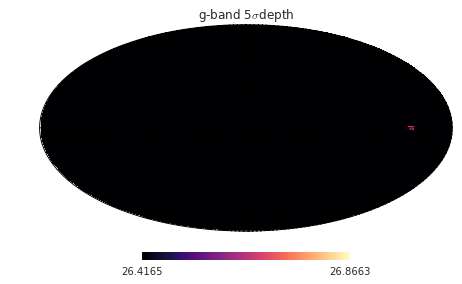

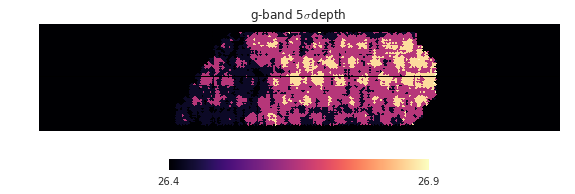

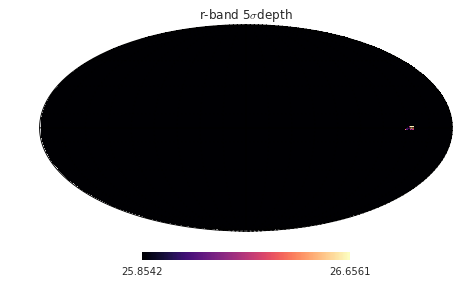

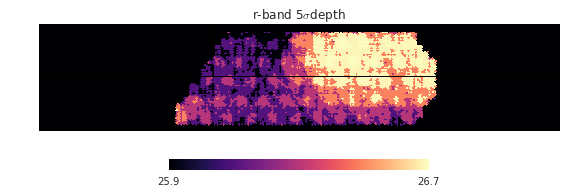

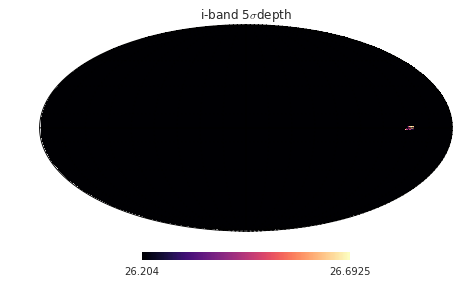

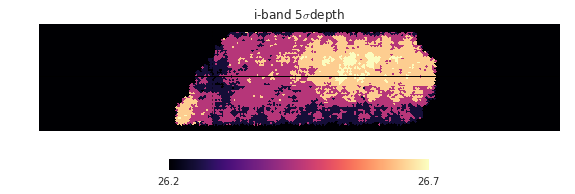

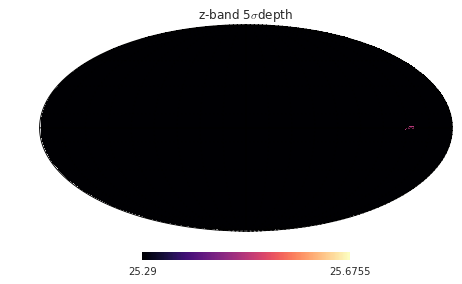

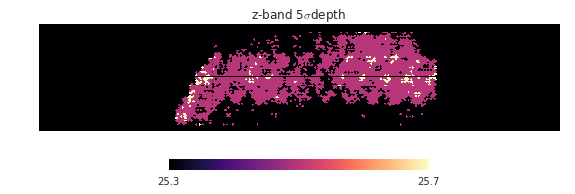

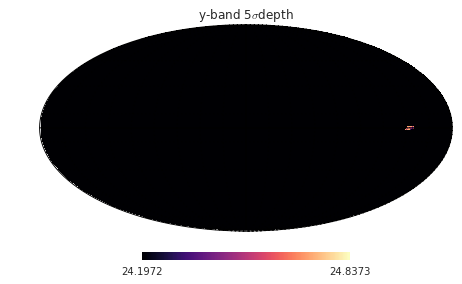

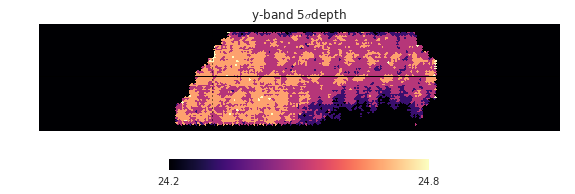

In [24]:
# create the 5sigma depth maps for each filter, using cmodel mags. plot skymaps + cartview.
hmaps= {}
for band in bands:
    key= '%scmodel'%band
    hmaps[band]= depth_map_snr(ra= HSCdata[goodKey]['ra'], dec= HSCdata[goodKey]['dec'],
                               mags= HSCdata[goodKey]['%s_mag'%key],
                               snr= HSCdata[goodKey]['%s-SNR'%key],
                               nside= nside)
    
    title= '%s-band 5$\sigma$depth'%band
    plotSkymap(hmaps[band], title= title)
    cartView(hmaps[band], raRange, decRange, title= title)

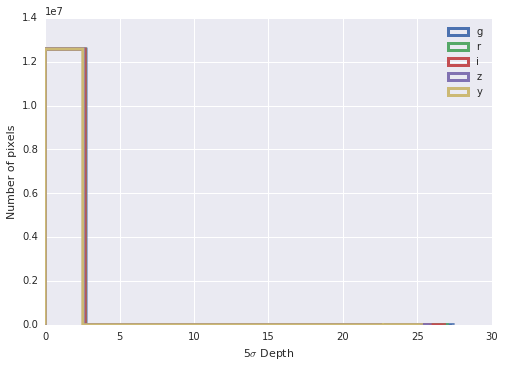

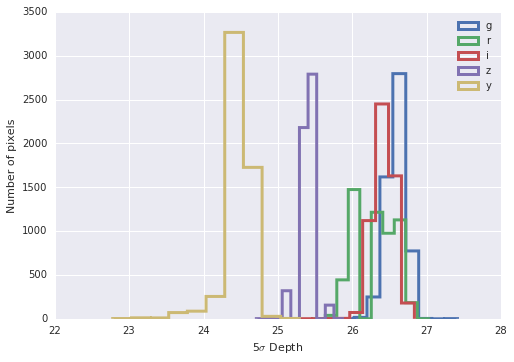

In [25]:
# plot histogram: number of pixels we have for different depth bins
fig, ax = plt.subplots()
for band in bands:
    plt.hist(hmaps[band], label= band, histtype= 'step', alpha= 1., lw= 3)
ax.legend()
ax.set_xlabel('5$\sigma$ Depth')
ax.set_ylabel('Number of pixels')

fig, ax = plt.subplots()
for band in bands:
    ind= np.where(hmaps[band]>0)[0]
    plt.hist(hmaps[band][ind], label= band, histtype= 'step', alpha= 1., lw= 3)
ax.legend()
ax.set_xlabel('5$\sigma$ Depth')
ax.set_ylabel('Number of pixels')

Ok: expected a lot of zeros in the depth map: most of the healpix map doesnt have data. zoom in looks ok.

Now find 5sigma depth for each object: ra, dec maps onto the healpix map.

In [26]:
pixelNumber= np.array(hp.ang2pix(nside, np.pi/2.-HSCdata[goodKey]['dec']*np.pi/180, HSCdata[goodKey]['ra']*np.pi/180))

In [27]:
# find five sigma depth for each object. add columns to dataframe.
fiveSigCols= []
for band in bands:
    key= '%s-5sigmaDepth'%band
    fiveSigCols.append(key)
    HSCdata[goodKey][key]= hmaps[band][pixelNumber]
    
fiveSigCols= np.array(fiveSigCols)
print 'Added cols:\n', fiveSigCols

Added cols:
['g-5sigmaDepth' 'r-5sigmaDepth' 'i-5sigmaDepth' 'z-5sigmaDepth'
 'y-5sigmaDepth']


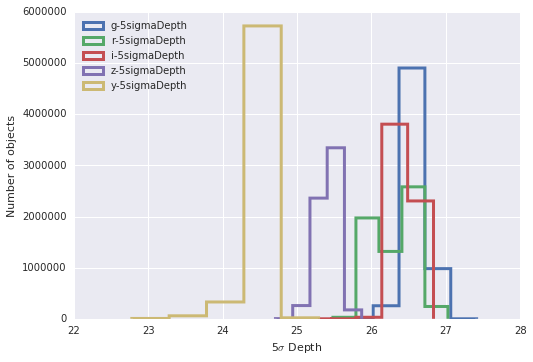

In [28]:
# plot histogram: number of objects we have for different depth bins
fig, ax = plt.subplots()
for key in fiveSigCols:
    plt.hist(HSCdata[goodKey][key], label= key, histtype= 'step', alpha= 1., lw= 3, bins= 5)
ax.legend(loc= "upper left")
ax.set_xlabel('5$\sigma$ Depth')
ax.set_ylabel('Number of objects')

Min: 25.0965517241, Max: 26.8344827586


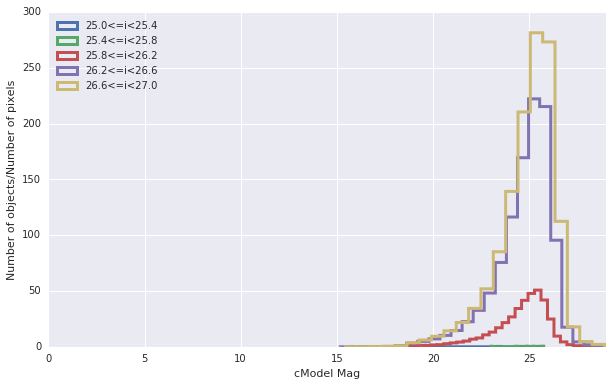

In [29]:
# plot object density as a function of 5sigma depth
densityTrend= OrderedDict()
for band in ['i']:
    fiveSigmaKey= '%s-5sigmaDepth'%band
    # find the min, max on the depth to decide on the bin ends.
    minDepth, maxDepth= stats(HSCdata[goodKey][fiveSigmaKey], returnData= True)
    minDepth, maxDepth= np.floor(minDepth), np.ceil(maxDepth)
    step= 0.4
    depthBins= np.arange(minDepth, maxDepth+step, step)
    
    # plot/store 
    plt.clf()
    fig, ax = plt.subplots()
    for i in range(len(depthBins)):
        if (i>0):
            magCutTag= '%s<=%s<%s'%(depthBins[i-1], band, depthBins[i])
            # find indices where 5sigma depth is within the depth range.
            fiveSigmaArr= np.array(HSCdata[goodKey][fiveSigmaKey])
            magCutInd= np.where((fiveSigmaArr>= depthBins[i-1]) & (fiveSigmaArr< depthBins[i]))[0]
            
            # histrogram the objects' mags that satisfy the 5sigma depth cut.
            # weight by the number of pixels.
            magArr= np.array(HSCdata[goodKey]['%scmodel_mag'%band])
            weight= np.ones(len(magCutInd))/np.count_nonzero((hmaps[band]>=depthBins[i-1])&(hmaps[band]<depthBins[i]))
            densityTrend[magCutTag]= plt.hist(magArr[magCutInd], weights= weight,
                                              label= magCutTag, histtype= 'step', alpha= 1., lw= 3, bins= 50)
    ax.legend(loc= 'upper left')
    ax.set_xlabel('cModel Mag')
    ax.set_ylabel('Number of objects/Number of pixels')
    ax.set_xlim(0, maxDepth+5*step)
    plt.gcf().set_size_inches(10,6)
    plt.show()

The plot looks weird: expect the rise to be similar (in scale, steepness) in different bins -- maybe a normalization issue or just a visualization problem?

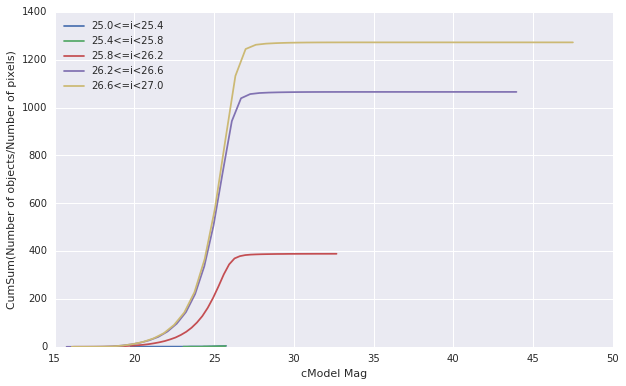

In [30]:
# try to look at the plot above another way?
for cut in densityTrend.keys():    
    plt.plot(densityTrend[cut][1][1:], np.cumsum(densityTrend[cut][0]), label= cut)
plt.legend(loc= 'upper left')
plt.xlabel('cModel Mag')
plt.ylabel('CumSum(Number of objects/Number of pixels)')
plt.gcf().set_size_inches(10,6)
plt.show()

ok i~25.8 might be a good limiting magnitude as cumulative sums dont improve beyond 5sigma depth of 25.8.